# Multi-VAE (Collaborative Filtering) Visualization

이 노트북은 학습된 Multi-VAE 모델과 추천 시스템 데이터를 시각화합니다:
1. Input Data 시각화: User-Item Matrix
2. Data Split 시각화: 4가지 분할 전략 비교
3. Prediction 시각화: Top-10 추천 및 Recall@K
4. 잠재 공간 시각화: 3D Multivariate Normal Distribution
5. 출력 분포 시각화: Multinomial Distribution

In [1]:
import os
import sys
import glob
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from hydra import initialize, compose
from omegaconf import OmegaConf
import logging
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

sys.path.append('..')
from src.models.multi_vae import MultiVAE
from src.data.recsys_data import RecSysDataModule
from src.utils.recommend import recommend_topk
from src.utils.metrics import recall_at_k

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# 한글폰트 : apt-get install -y fonts-nanum
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

# 모델 이름 (Hydra 로그 디렉토리 구조)
MODEL_NAME = "multi-vae"

In [2]:
# run_timestamp 설정 (None이면 가장 최근 실행 자동 선택)
run_timestamp = None  # 예: "2025-12-20/16-44-09"

# 가장 최근 실행 찾기
def find_latest_run(base_dir=f"../saved/hydra_logs/{MODEL_NAME}"):
    """가장 최근 실행 디렉토리 찾기"""
    pattern = os.path.join(base_dir, "*", "*")
    all_runs = glob.glob(pattern)
    
    if not all_runs:
        raise FileNotFoundError(f"No run directories found in {base_dir}")
    
    # 날짜/시간 기준으로 정렬
    all_runs.sort()
    latest_run = all_runs[-1]
    
    # 상대 경로로 변환: saved/hydra_logs/2025-12-20/16-44-09 -> 2025-12-20/16-44-09
    run_timestamp = os.path.relpath(latest_run, base_dir)
    
    return run_timestamp

if run_timestamp is None:
    run_timestamp = find_latest_run()
    print(f"✅ Using latest run: {run_timestamp}")
else:
    print(f"✅ Using specified run: {run_timestamp}")

# Hydra 설정 로드
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="multi_vae")

print("\n" + "="*80)
print("Configuration:")
print(OmegaConf.to_yaml(cfg))
print("="*80)

✅ Using latest run: 2025-12-21/16-58-13

Configuration:
tensorboard:
  save_dir: ./saved/tensorboard_logs
checkpoint:
  save_top_k: 1
  monitor: val_loss
  mode: min
seed: 42
float32_matmul_precision: medium
model_name: multi-vae
data:
  data_dir: ~/data/train/
  batch_size: 512
  valid_ratio: 0.1
  min_interactions: 5
  data_file: train_ratings.csv
  split_strategy: temporal_user
  temporal_split_ratio: 0.9
model:
  hidden_dims:
  - 600
  - 200
  dropout: 0.5
training:
  max_epochs: 500
  lr: 0.001
  weight_decay: 0.01
  kl_max_weight: 0.2
  kl_anneal_steps: 20000
trainer:
  devices: auto
  log_every_n_steps: 10
  val_check_interval: 1.0
  enable_progress_bar: true
  enable_model_summary: true
recommend:
  topk: 10



In [3]:
# 데이터 로드
data_module = RecSysDataModule(
    data_dir=cfg.data.data_dir,
    batch_size=cfg.data.batch_size,
    valid_ratio=cfg.data.valid_ratio,
    min_interactions=cfg.data.min_interactions,
    seed=cfg.seed,
    data_file=cfg.data.data_file,
    split_strategy=cfg.data.split_strategy,
    temporal_split_ratio=cfg.data.get("temporal_split_ratio", 0.8),
)
data_module.setup()

print(f"Number of users: {data_module.num_users}")
print(f"Number of items: {data_module.num_items}")
print(f"Split strategy: {data_module.split_strategy}")

Number of users: 31360
Number of items: 6807
Split strategy: temporal_user


In [4]:
# 체크포인트 로드 (Hydra 실행 디렉토리 기준)
checkpoint_dir = os.path.join('..', 'saved', 'hydra_logs', MODEL_NAME, run_timestamp, 'checkpoints')

if not os.path.exists(checkpoint_dir):
    raise FileNotFoundError(f"Checkpoint directory not found: {checkpoint_dir}")

# 체크포인트 파일 찾기
checkpoints = glob.glob(os.path.join(checkpoint_dir, "multi-vae-*.ckpt"))

if not checkpoints:
    raise FileNotFoundError(f"No checkpoints found in {checkpoint_dir}")

# 가장 좋은 체크포인트 선택 (val_loss 기준)
# 파일명: multi-vae-epoch=XX-val_loss=YY.YYYY.ckpt
def extract_val_loss(ckpt_path):
    filename = os.path.basename(ckpt_path)
    try:
        loss_str = filename.split("val_loss=")[1].split(".ckpt")[0]
        return float(loss_str)
    except:
        return float('inf')

best_checkpoint = min(checkpoints, key=extract_val_loss)
print(f"✅ Loading checkpoint: {best_checkpoint}")

# 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiVAE.load_from_checkpoint(
    best_checkpoint,
    num_items=data_module.num_items,
    weights_only=False
)
model.to(device)
model.eval()
print(f"✅ Model loaded on {device}")

✅ Loading checkpoint: ../saved/hydra_logs/multi-vae/2025-12-21/16-58-13/checkpoints/multi-vae-epoch=462-val_loss=906.2752.ckpt
✅ Model loaded on cuda


## 1. Input Data 시각화: User-Item Matrix

User-Item 상호작용 행렬을 시각화합니다.

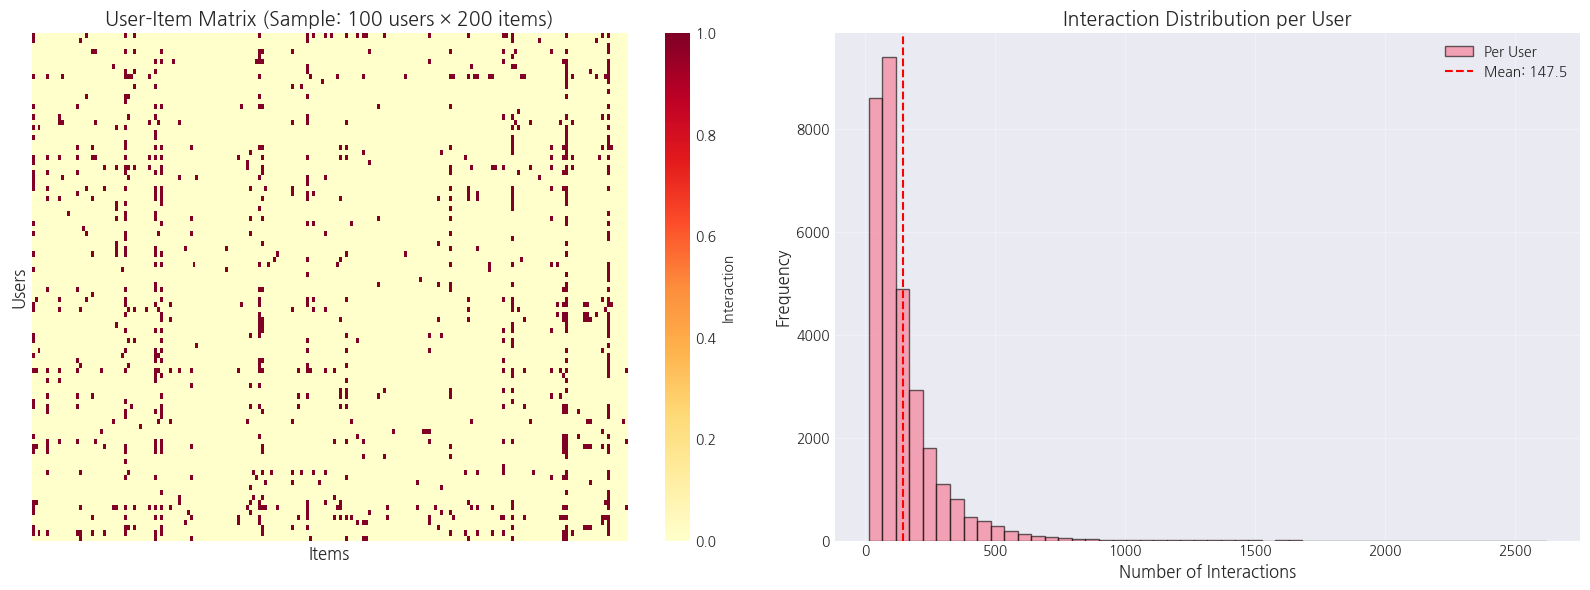


=== User-Item Matrix Statistics ===
Total Users: 31,360
Total Items: 6,807
Total Interactions: 4,625,057
Matrix Sparsity: 97.83%

Interactions per User: mean=147.5, median=102.0
Interactions per Item: mean=679.5, median=167.0


In [5]:
def visualize_user_item_matrix(train_mat, num_users=100, num_items=200):
    """
    User-Item 행렬 시각화 (샘플링)
    """
    # 샘플링 (너무 크면 일부만)
    sample_users = min(num_users, train_mat.shape[0])
    sample_items = min(num_items, train_mat.shape[1])
    
    # Dense로 변환 (샘플만)
    sample_mat = train_mat[:sample_users, :sample_items].toarray()
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Heatmap
    sns.heatmap(sample_mat, cmap='YlOrRd', cbar_kws={'label': 'Interaction'},
                ax=axes[0], xticklabels=False, yticklabels=False)
    axes[0].set_title(f'User-Item Matrix (Sample: {sample_users} users × {sample_items} items)', fontsize=14)
    axes[0].set_xlabel('Items', fontsize=12)
    axes[0].set_ylabel('Users', fontsize=12)
    
    # 2. 통계
    total_interactions = train_mat.nnz
    total_possible = train_mat.shape[0] * train_mat.shape[1]
    sparsity = 100 * (1 - total_interactions / total_possible)
    
    interactions_per_user = np.array(train_mat.sum(axis=1)).flatten()
    interactions_per_item = np.array(train_mat.sum(axis=0)).flatten()
    
    axes[1].hist(interactions_per_user, bins=50, alpha=0.6, label='Per User', edgecolor='black')
    axes[1].axvline(interactions_per_user.mean(), color='red', linestyle='--', 
                    label=f'Mean: {interactions_per_user.mean():.1f}')
    axes[1].set_xlabel('Number of Interactions', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Interaction Distribution per User', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 출력
    print(f"\n=== User-Item Matrix Statistics ===")
    print(f"Total Users: {train_mat.shape[0]:,}")
    print(f"Total Items: {train_mat.shape[1]:,}")
    print(f"Total Interactions: {total_interactions:,}")
    print(f"Matrix Sparsity: {sparsity:.2f}%")
    print(f"\nInteractions per User: mean={interactions_per_user.mean():.1f}, median={np.median(interactions_per_user):.1f}")
    print(f"Interactions per Item: mean={interactions_per_item.mean():.1f}, median={np.median(interactions_per_item):.1f}")

train_mat = data_module.get_train_matrix()
visualize_user_item_matrix(train_mat)

## 2. Data Split 시각화: 4가지 분할 전략

Random, Leave-One-Out, Temporal User, Temporal Global 분할 전략을 비교합니다.

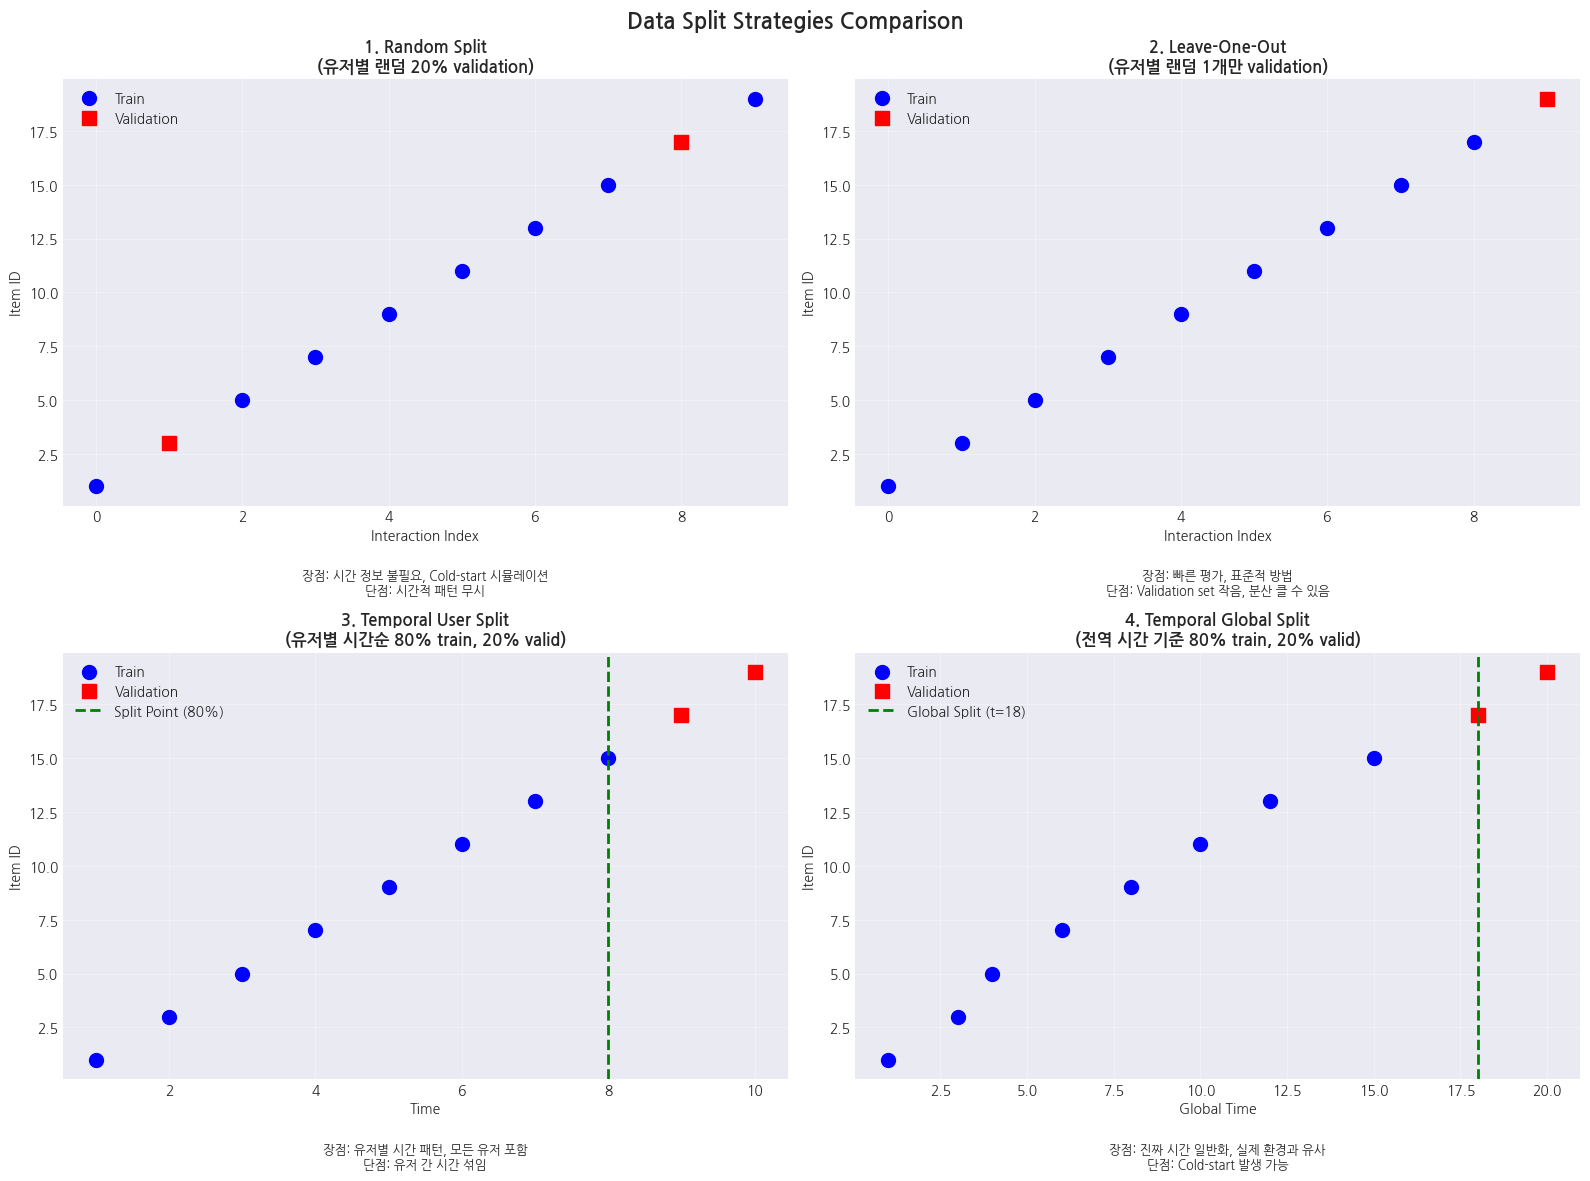

In [6]:
def visualize_split_strategies():
    """
    4가지 split 전략을 시각적으로 비교
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Data Split Strategies Comparison', fontsize=16, fontweight='bold')
    
    # 샘플 유저 데이터 (시각화용)
    user_items = np.array([1, 3, 5, 7, 9, 11, 13, 15, 17, 19])  # 10개 아이템
    timestamps = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])  # 시간 순서
    
    # 1. Random Split
    ax = axes[0, 0]
    np.random.seed(42)
    valid_idx = np.random.choice(len(user_items), size=2, replace=False)
    train_mask = np.ones(len(user_items), dtype=bool)
    train_mask[valid_idx] = False
    
    ax.scatter(np.arange(len(user_items))[train_mask], user_items[train_mask], 
               c='blue', s=100, label='Train', marker='o')
    ax.scatter(np.arange(len(user_items))[~train_mask], user_items[~train_mask], 
               c='red', s=100, label='Validation', marker='s')
    ax.set_title('1. Random Split\n(유저별 랜덤 20% validation)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Interaction Index', fontsize=10)
    ax.set_ylabel('Item ID', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -0.15, '장점: 시간 정보 불필요, Cold-start 시뮬레이션\n단점: 시간적 패턴 무시',
            ha='center', va='top', transform=ax.transAxes, fontsize=9, style='italic')
    
    # 2. Leave-One-Out
    ax = axes[0, 1]
    train_mask = np.ones(len(user_items), dtype=bool)
    train_mask[-1] = False  # 마지막 1개만 validation
    
    ax.scatter(np.arange(len(user_items))[train_mask], user_items[train_mask], 
               c='blue', s=100, label='Train', marker='o')
    ax.scatter(np.arange(len(user_items))[~train_mask], user_items[~train_mask], 
               c='red', s=100, label='Validation', marker='s')
    ax.set_title('2. Leave-One-Out\n(유저별 랜덤 1개만 validation)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Interaction Index', fontsize=10)
    ax.set_ylabel('Item ID', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -0.15, '장점: 빠른 평가, 표준적 방법\n단점: Validation set 작음, 분산 클 수 있음',
            ha='center', va='top', transform=ax.transAxes, fontsize=9, style='italic')
    
    # 3. Temporal User Split
    ax = axes[1, 0]
    split_idx = int(len(user_items) * 0.8)  # 80% train
    train_mask = np.zeros(len(user_items), dtype=bool)
    train_mask[:split_idx] = True
    
    ax.scatter(timestamps[train_mask], user_items[train_mask], 
               c='blue', s=100, label='Train', marker='o')
    ax.scatter(timestamps[~train_mask], user_items[~train_mask], 
               c='red', s=100, label='Validation', marker='s')
    ax.axvline(x=timestamps[split_idx-1], color='green', linestyle='--', 
               linewidth=2, label='Split Point (80%)')
    ax.set_title('3. Temporal User Split\n(유저별 시간순 80% train, 20% valid)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('Item ID', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -0.15, '장점: 유저별 시간 패턴, 모든 유저 포함\n단점: 유저 간 시간 섞임',
            ha='center', va='top', transform=ax.transAxes, fontsize=9, style='italic')
    
    # 4. Temporal Global Split
    ax = axes[1, 1]
    # Global timeline 시뮬레이션
    global_time = np.array([1, 3, 4, 6, 8, 10, 12, 15, 18, 20])  # 전역 시간
    split_time = global_time[int(len(global_time) * 0.8)]  # 80% 지점
    train_mask = global_time < split_time
    
    ax.scatter(global_time[train_mask], user_items[train_mask], 
               c='blue', s=100, label='Train', marker='o')
    ax.scatter(global_time[~train_mask], user_items[~train_mask], 
               c='red', s=100, label='Validation', marker='s')
    ax.axvline(x=split_time, color='green', linestyle='--', 
               linewidth=2, label=f'Global Split (t={split_time})')
    ax.set_title('4. Temporal Global Split\n(전역 시간 기준 80% train, 20% valid)', fontsize=12, fontweight='bold')
    ax.set_xlabel('Global Time', fontsize=10)
    ax.set_ylabel('Item ID', fontsize=10)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.text(0.5, -0.15, '장점: 진짜 시간 일반화, 실제 환경과 유사\n단점: Cold-start 발생 가능',
            ha='center', va='top', transform=ax.transAxes, fontsize=9, style='italic')
    
    plt.tight_layout()
    plt.show()

visualize_split_strategies()

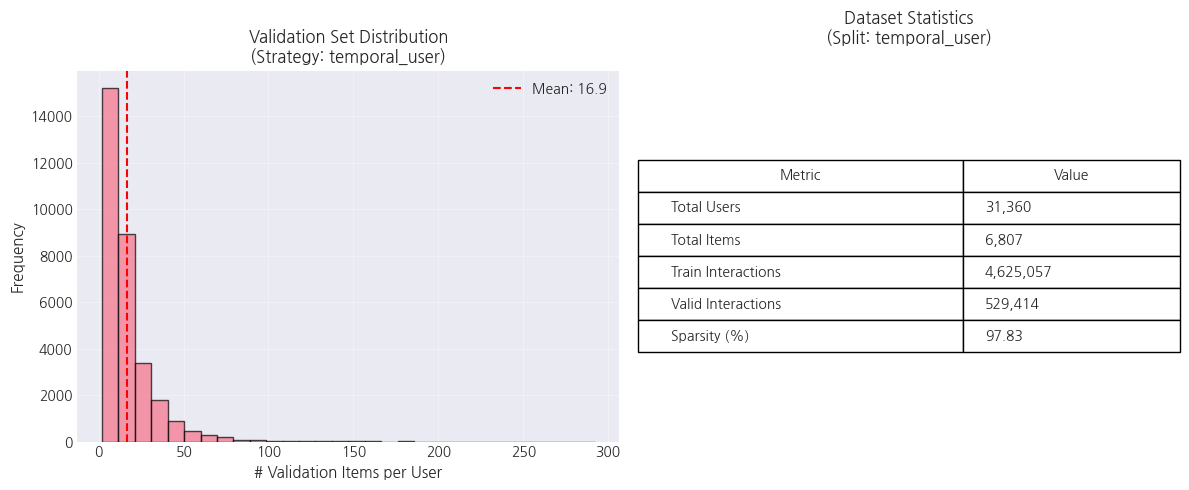

In [7]:
# 현재 사용 중인 split strategy 통계
valid_gt = data_module.get_validation_ground_truth()
valid_counts = [len(items) for items in valid_gt.values()]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(valid_counts, bins=30, edgecolor='black', alpha=0.7)
plt.axvline(np.mean(valid_counts), color='red', linestyle='--', 
            label=f'Mean: {np.mean(valid_counts):.1f}')
plt.xlabel('# Validation Items per User', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.title(f'Validation Set Distribution\n(Strategy: {data_module.split_strategy})', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
stats_data = {
    'Metric': ['Total Users', 'Total Items', 'Train Interactions', 'Valid Interactions', 'Sparsity (%)'],
    'Value': [
        f"{data_module.num_users:,}",
        f"{data_module.num_items:,}",
        f"{train_mat.nnz:,}",
        f"{sum(valid_counts):,}",
        f"{100 * (1 - train_mat.nnz / (data_module.num_users * data_module.num_items)):.2f}"
    ]
}
df_stats = pd.DataFrame(stats_data)
plt.axis('off')
table = plt.table(cellText=df_stats.values, colLabels=df_stats.columns,
                  cellLoc='left', loc='center', colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
plt.title(f'Dataset Statistics\n(Split: {data_module.split_strategy})', fontsize=12, pad=20)

plt.tight_layout()
plt.show()

## 3. Prediction 시각화: Top-10 추천 및 Recall@K

모델의 Top-K 추천 결과와 평가 메트릭을 시각화합니다.

In [8]:
# Top-K 추천 생성
print("Generating Top-K recommendations...")
recommendations = recommend_topk(
    model,
    train_mat,
    k=cfg.recommend.topk,
    device=device,
    batch_size=cfg.data.batch_size
)

# Recall@K 계산
valid_gt_list = [valid_gt[u] for u in range(data_module.num_users)]
pred_list = [rec.tolist() for rec in recommendations]
recall = recall_at_k(valid_gt_list, pred_list, k=cfg.recommend.topk)

print(f"\nValidation Recall@{cfg.recommend.topk}: {recall:.4f}")

Generating Top-K recommendations...

Validation Recall@10: 0.0970


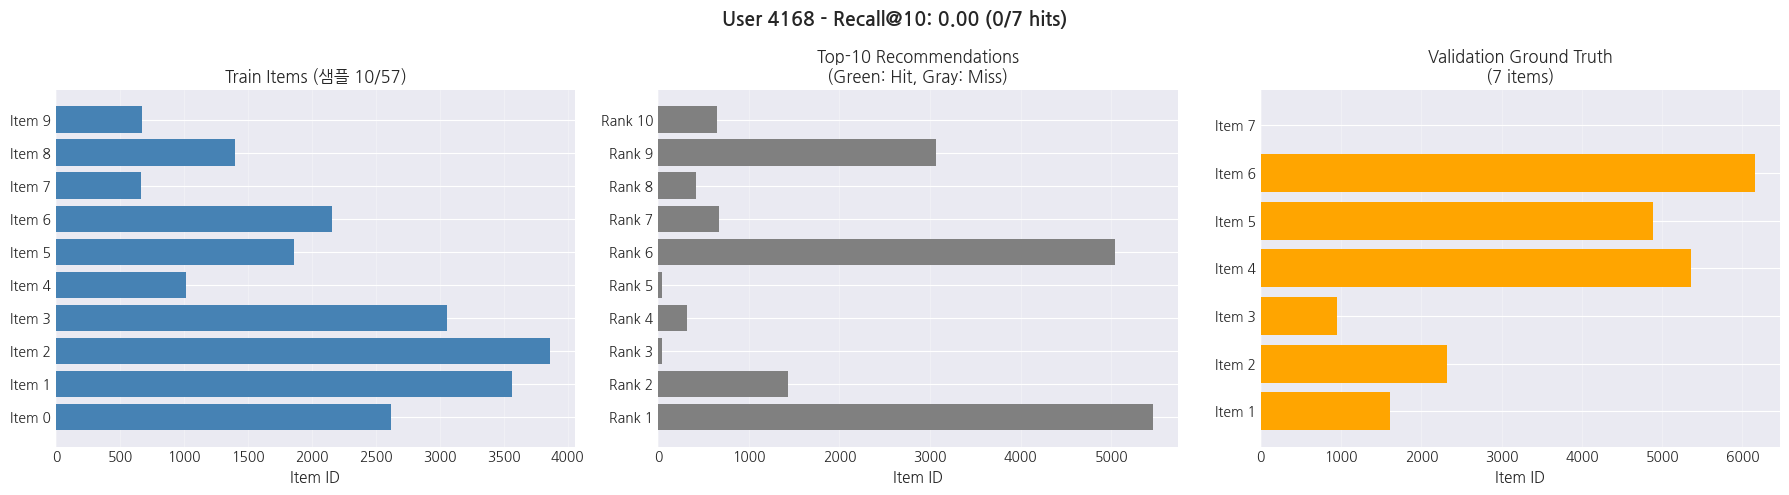

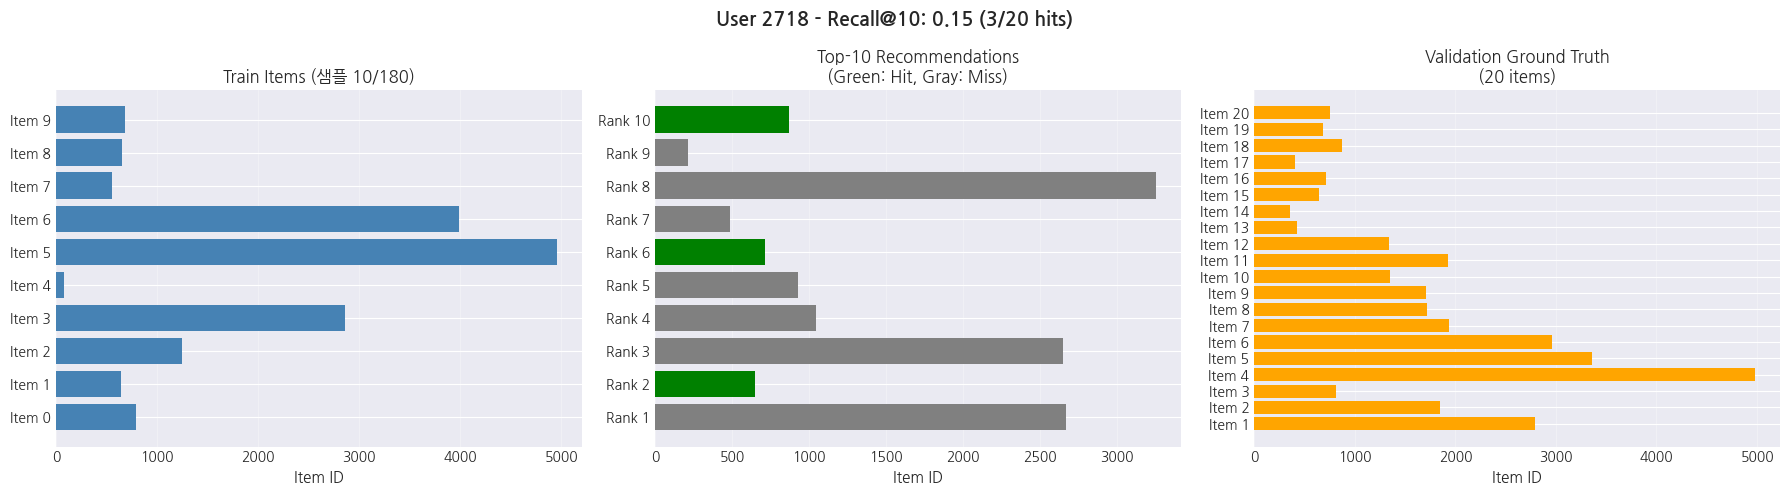

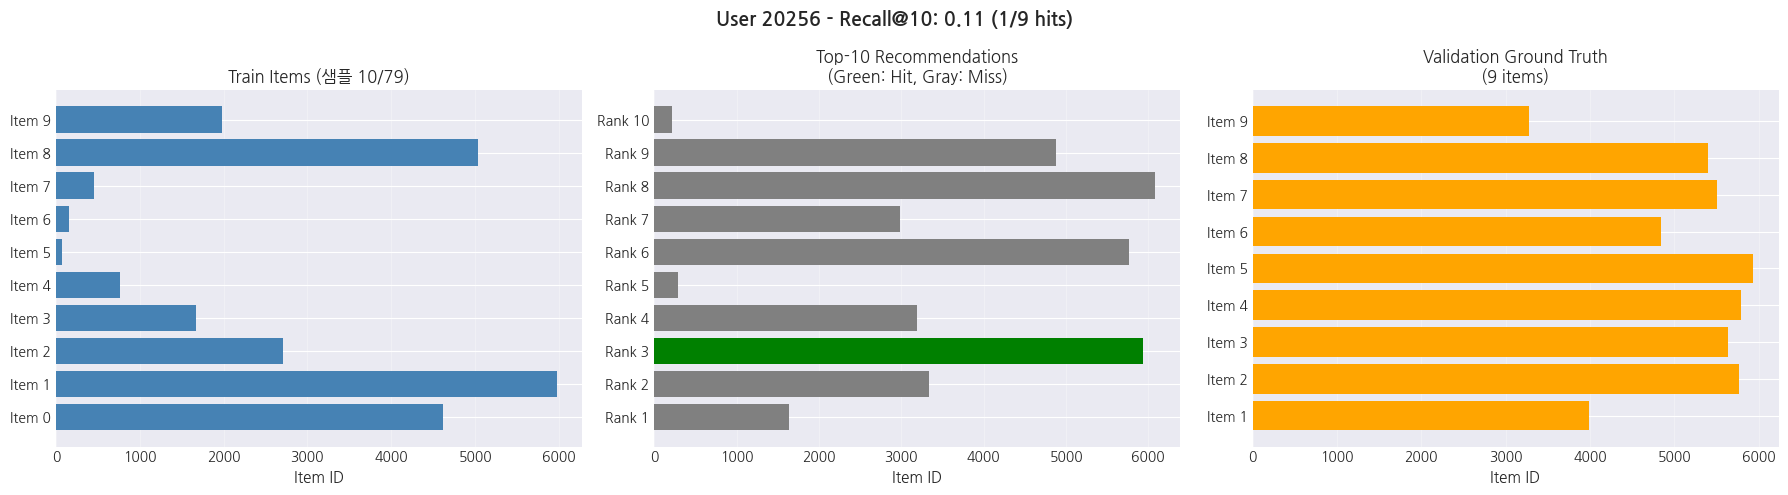

In [9]:
def visualize_recommendations(user_idx, train_mat, recommendations, valid_gt, num_show=10):
    """
    특정 유저의 추천 결과 시각화
    """
    # 유저 데이터
    user_train = train_mat[user_idx].toarray().flatten()
    user_train_items = np.where(user_train > 0)[0]
    user_recs = recommendations[user_idx]
    user_valid = valid_gt[user_idx]
    
    # Hit 계산
    hits = [item in user_valid for item in user_recs]
    n_hits = sum(hits)
    user_recall = n_hits / len(user_valid) if len(user_valid) > 0 else 0
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 1. Train items
    ax = axes[0]
    if len(user_train_items) > num_show:
        sample_train = np.random.choice(user_train_items, num_show, replace=False)
    else:
        sample_train = user_train_items
    
    ax.barh(range(len(sample_train)), sample_train, color='steelblue')
    ax.set_yticks(range(len(sample_train)))
    ax.set_yticklabels([f'Item {i}' for i in range(len(sample_train))])
    ax.set_xlabel('Item ID', fontsize=11)
    ax.set_title(f'Train Items (샘플 {len(sample_train)}/{len(user_train_items)})', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # 2. Recommendations
    ax = axes[1]
    colors = ['green' if hit else 'gray' for hit in hits]
    ax.barh(range(len(user_recs)), user_recs, color=colors)
    ax.set_yticks(range(len(user_recs)))
    ax.set_yticklabels([f'Rank {i+1}' for i in range(len(user_recs))])
    ax.set_xlabel('Item ID', fontsize=11)
    ax.set_title(f'Top-{len(user_recs)} Recommendations\n(Green: Hit, Gray: Miss)', fontsize=12)
    ax.grid(True, alpha=0.3, axis='x')
    
    # 3. Validation GT
    ax = axes[2]
    if len(user_valid) > 0:
        ax.barh(range(len(user_valid)), user_valid, color='orange')
        ax.set_yticks(range(len(user_valid)))
        ax.set_yticklabels([f'Item {i+1}' for i in range(len(user_valid))])
        ax.set_xlabel('Item ID', fontsize=11)
        ax.set_title(f'Validation Ground Truth\n({len(user_valid)} items)', fontsize=12)
        ax.grid(True, alpha=0.3, axis='x')
    else:
        ax.text(0.5, 0.5, 'No validation items', ha='center', va='center',
                transform=ax.transAxes, fontsize=14)
        ax.axis('off')
    
    fig.suptitle(f'User {user_idx} - Recall@{len(user_recs)}: {user_recall:.2f} ({n_hits}/{len(user_valid)} hits)',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 여러 유저 샘플 시각화
sample_users = np.random.choice(data_module.num_users, size=3, replace=False)
for user_idx in sample_users:
    visualize_recommendations(user_idx, train_mat, recommendations, valid_gt)

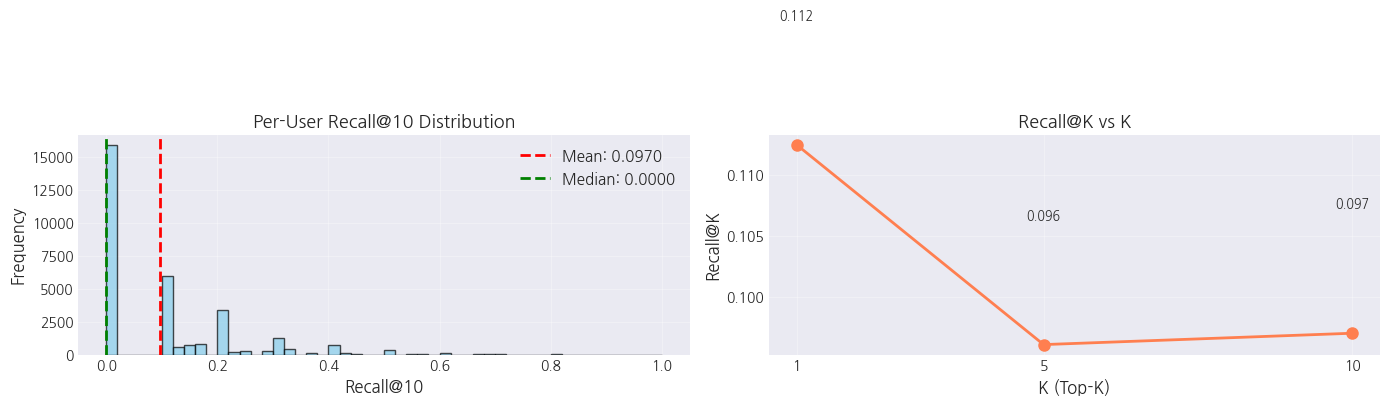

In [10]:
# Recall@K 분포 시각화
user_recalls = []
for u in range(data_module.num_users):
    if len(valid_gt[u]) > 0:
        hits = len(set(recommendations[u].tolist()) & set(valid_gt[u]))
        user_recall = hits / min(cfg.recommend.topk, len(valid_gt[u]))
        user_recalls.append(user_recall)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(user_recalls, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.axvline(np.mean(user_recalls), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {np.mean(user_recalls):.4f}')
plt.axvline(np.median(user_recalls), color='green', linestyle='--', linewidth=2,
            label=f'Median: {np.median(user_recalls):.4f}')
plt.xlabel(f'Recall@{cfg.recommend.topk}', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Per-User Recall@{cfg.recommend.topk} Distribution', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
recall_values = []
k_values = [1, 5, 10, 20, 50]
for k in k_values:
    if k <= cfg.recommend.topk:
        pred_k = [rec[:k].tolist() for rec in recommendations]
        recall_k = recall_at_k(valid_gt_list, pred_k, k=k)
        recall_values.append(recall_k)
    else:
        break

valid_k = k_values[:len(recall_values)]
plt.plot(valid_k, recall_values, marker='o', linewidth=2, markersize=8, color='coral')
plt.xlabel('K (Top-K)', fontsize=12)
plt.ylabel('Recall@K', fontsize=12)
plt.title('Recall@K vs K', fontsize=13)
plt.grid(True, alpha=0.3)
plt.xticks(valid_k)

for i, (k, r) in enumerate(zip(valid_k, recall_values)):
    plt.text(k, r + 0.01, f'{r:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

## 4. 잠재 공간 시각화: 3D Multivariate Normal Distribution

유저들의 잠재 표현(latent representation)을 시각화하고, Multivariate Normal Distribution을 3차원으로 표현합니다.

In [11]:
# 유저 잠재 벡터 추출
print("Extracting user latent representations...")
train_dense = torch.FloatTensor(train_mat.toarray()).to(device)

with torch.no_grad():
    mu, logvar = model.encode(train_dense)
    mu = mu.cpu().numpy()
    logvar = logvar.cpu().numpy()
    std = np.exp(0.5 * logvar)

latent_dim = mu.shape[1]
print(f"Latent dimension: {latent_dim}")
print(f"Number of users: {mu.shape[0]}")

Extracting user latent representations...
Latent dimension: 200
Number of users: 31360


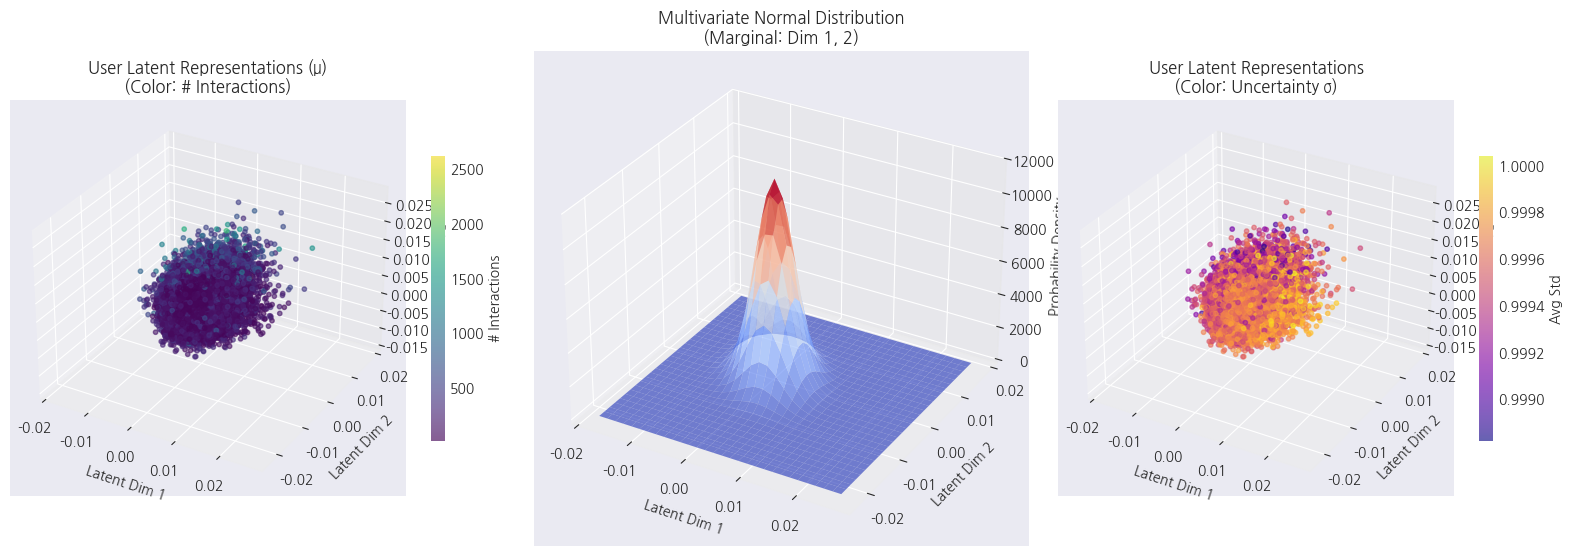

In [12]:
# 3차원 시각화 (처음 3개 차원 사용)
if latent_dim >= 3:
    fig = plt.figure(figsize=(16, 6))
    
    # 1. 유저별 mu 분포 (3D scatter)
    ax1 = fig.add_subplot(131, projection='3d')
    
    # 상호작용 개수로 색상 구분
    n_interactions = np.array(train_mat.sum(axis=1)).flatten()
    scatter = ax1.scatter(mu[:, 0], mu[:, 1], mu[:, 2], 
                         c=n_interactions, cmap='viridis', s=10, alpha=0.6)
    ax1.set_xlabel('Latent Dim 1', fontsize=10)
    ax1.set_ylabel('Latent Dim 2', fontsize=10)
    ax1.set_zlabel('Latent Dim 3', fontsize=10)
    ax1.set_title('User Latent Representations (μ)\n(Color: # Interactions)', fontsize=12)
    plt.colorbar(scatter, ax=ax1, shrink=0.5, label='# Interactions')
    
    # 2. Multivariate Normal Distribution (등고선)
    ax2 = fig.add_subplot(132, projection='3d')
    
    # 전체 분포의 평균과 공분산
    mean_mu = mu[:, :3].mean(axis=0)
    cov_mu = np.cov(mu[:, :3].T)
    
    # Grid 생성
    x = np.linspace(mu[:, 0].min(), mu[:, 0].max(), 30)
    y = np.linspace(mu[:, 1].min(), mu[:, 1].max(), 30)
    X, Y = np.meshgrid(x, y)
    
    # 2D marginal distribution (dim 0, 1)
    pos = np.dstack((X, Y))
    rv = multivariate_normal(mean_mu[:2], cov_mu[:2, :2])
    Z = rv.pdf(pos)
    
    ax2.plot_surface(X, Y, Z, cmap='coolwarm', alpha=0.7, edgecolor='none')
    ax2.set_xlabel('Latent Dim 1', fontsize=10)
    ax2.set_ylabel('Latent Dim 2', fontsize=10)
    ax2.set_zlabel('Probability Density', fontsize=10)
    ax2.set_title('Multivariate Normal Distribution\n(Marginal: Dim 1, 2)', fontsize=12)
    
    # 3. Uncertainty (std) 시각화
    ax3 = fig.add_subplot(133, projection='3d')
    
    uncertainty = std[:, :3].mean(axis=1)  # 평균 불확실성
    scatter = ax3.scatter(mu[:, 0], mu[:, 1], mu[:, 2], 
                         c=uncertainty, cmap='plasma', s=10, alpha=0.6)
    ax3.set_xlabel('Latent Dim 1', fontsize=10)
    ax3.set_ylabel('Latent Dim 2', fontsize=10)
    ax3.set_zlabel('Latent Dim 3', fontsize=10)
    ax3.set_title('User Latent Representations\n(Color: Uncertainty σ)', fontsize=12)
    plt.colorbar(scatter, ax=ax3, shrink=0.5, label='Avg Std')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"Latent dimension ({latent_dim}) < 3, skipping 3D visualization")

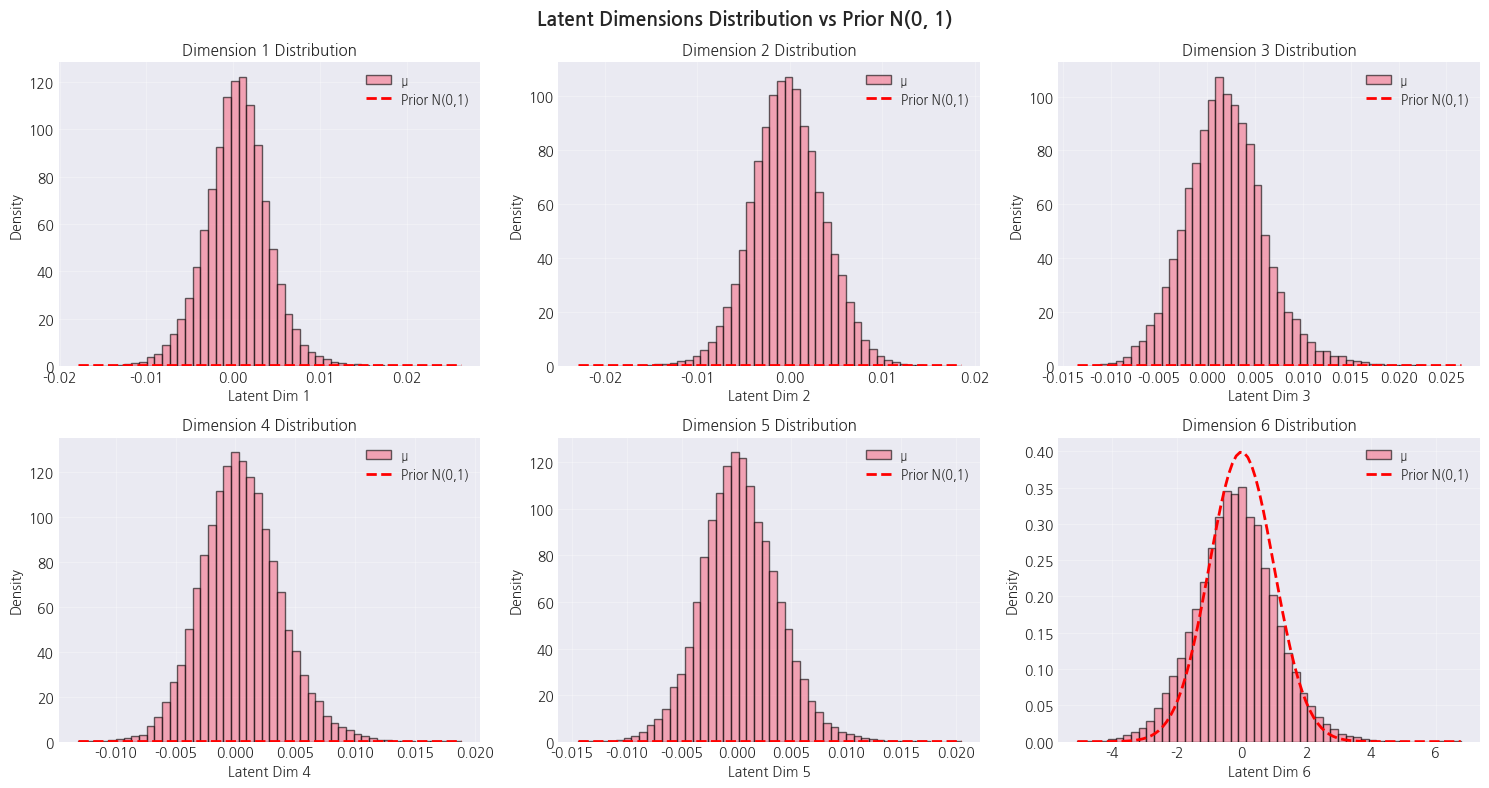

In [13]:
# 차원별 분포 시각화
n_dims_to_plot = min(6, latent_dim)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i in range(n_dims_to_plot):
    ax = axes[i]
    
    # Histogram with KDE
    ax.hist(mu[:, i], bins=50, alpha=0.6, density=True, edgecolor='black', label='μ')
    
    # Prior N(0, 1)
    x_range = np.linspace(mu[:, i].min(), mu[:, i].max(), 100)
    prior = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * x_range**2)
    ax.plot(x_range, prior, 'r--', linewidth=2, label='Prior N(0,1)')
    
    ax.set_xlabel(f'Latent Dim {i+1}', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.set_title(f'Dimension {i+1} Distribution', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Latent Dimensions Distribution vs Prior N(0, 1)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. 출력 분포 시각화: Multinomial Distribution

모델의 출력 분포(Multinomial Distribution)를 시각화합니다.

In [14]:
# 샘플 유저들의 출력 분포 계산
sample_users_idx = np.random.choice(data_module.num_users, size=5, replace=False)
sample_users_data = train_dense[sample_users_idx]

with torch.no_grad():
    logits, _, _ = model(sample_users_data)
    probs = torch.softmax(logits, dim=1).cpu().numpy()

print(f"Output shape: {probs.shape}")
print(f"Probability sum per user: {probs.sum(axis=1)}")

Output shape: (5, 6807)
Probability sum per user: [1.         0.9999999  0.99999994 0.99999994 1.        ]


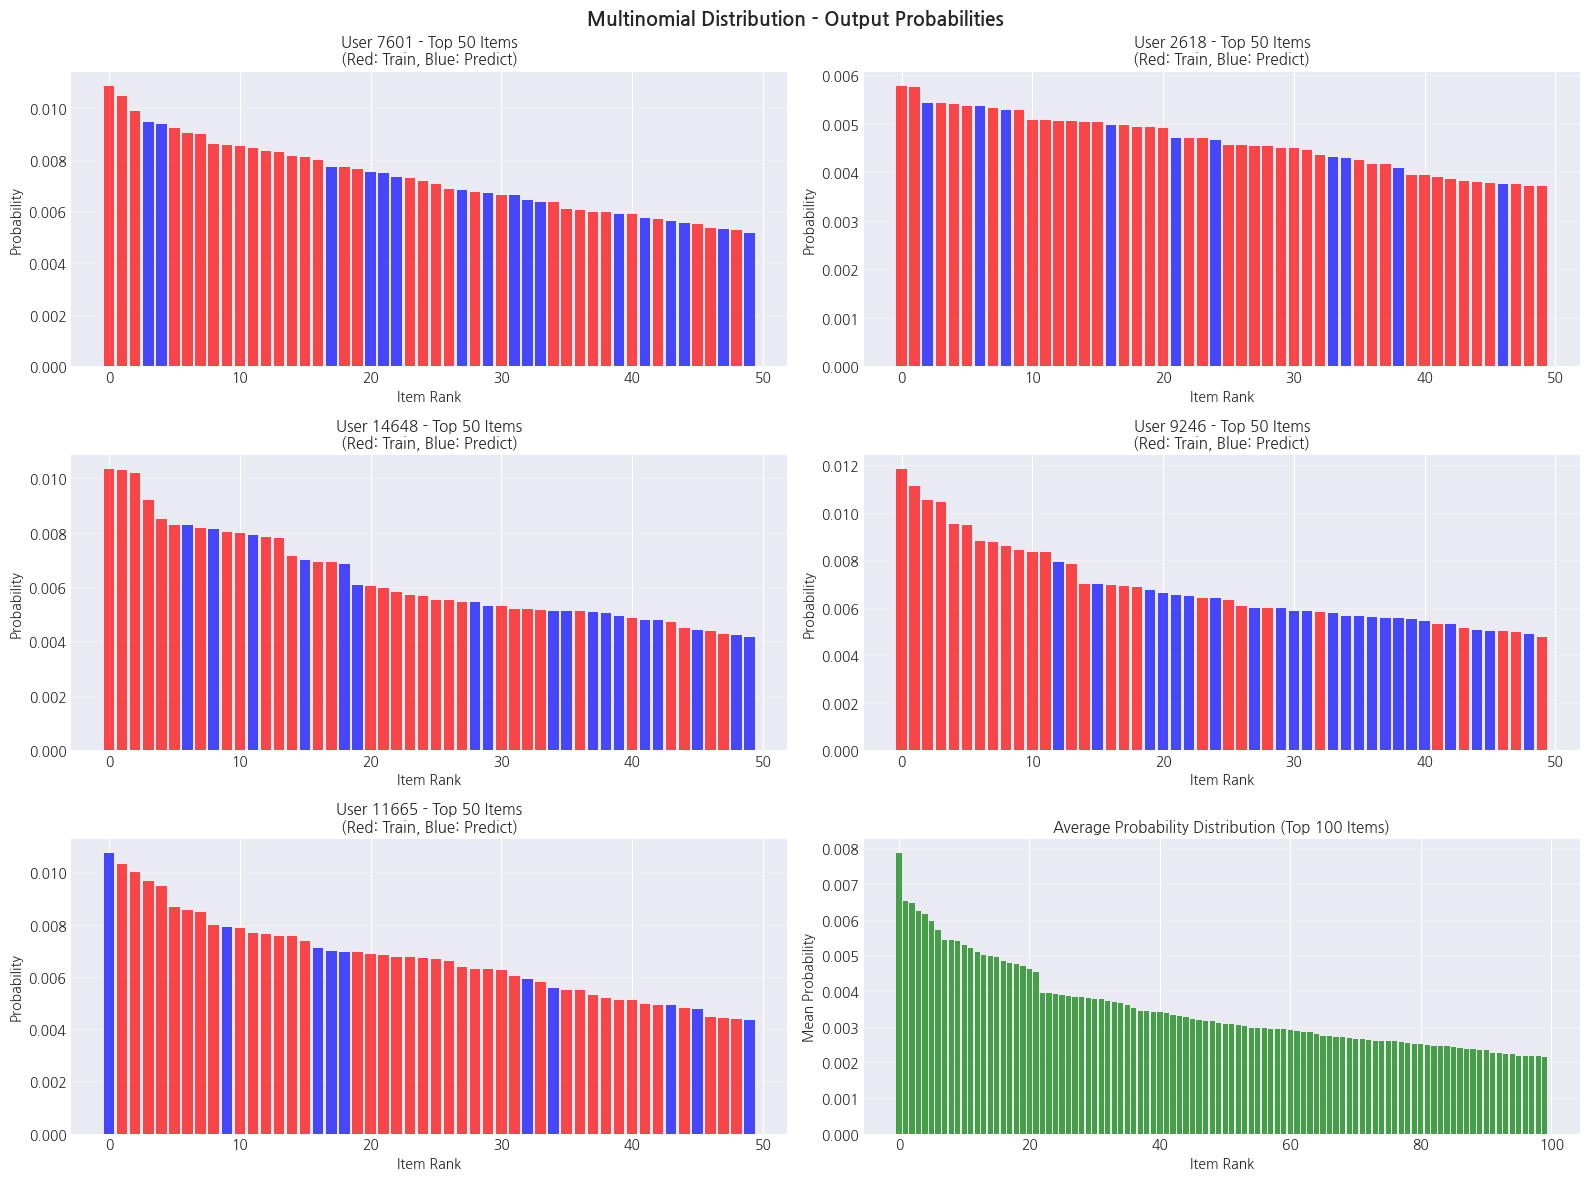

In [15]:
# 유저별 출력 분포 시각화
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, user_idx in enumerate(sample_users_idx):
    ax = axes[idx]
    
    user_probs = probs[idx]
    user_train_items = np.where(sample_users_data[idx].cpu().numpy() > 0)[0]
    
    # Top-K 아이템 선택
    top_k_idx = np.argsort(user_probs)[-50:][::-1]  # Top 50
    
    colors = ['red' if i in user_train_items else 'blue' for i in top_k_idx]
    
    ax.bar(range(len(top_k_idx)), user_probs[top_k_idx], color=colors, alpha=0.7)
    ax.set_xlabel('Item Rank', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.set_title(f'User {sample_users_idx[idx]} - Top 50 Items\n(Red: Train, Blue: Predict)', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

# 마지막 서브플롯: 전체 평균 분포
ax = axes[-1]
mean_probs = probs.mean(axis=0)
sorted_idx = np.argsort(mean_probs)[::-1][:100]  # Top 100

ax.bar(range(len(sorted_idx)), mean_probs[sorted_idx], color='green', alpha=0.7)
ax.set_xlabel('Item Rank', fontsize=10)
ax.set_ylabel('Mean Probability', fontsize=10)
ax.set_title('Average Probability Distribution (Top 100 Items)', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Multinomial Distribution - Output Probabilities', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Computing entropy for all users...


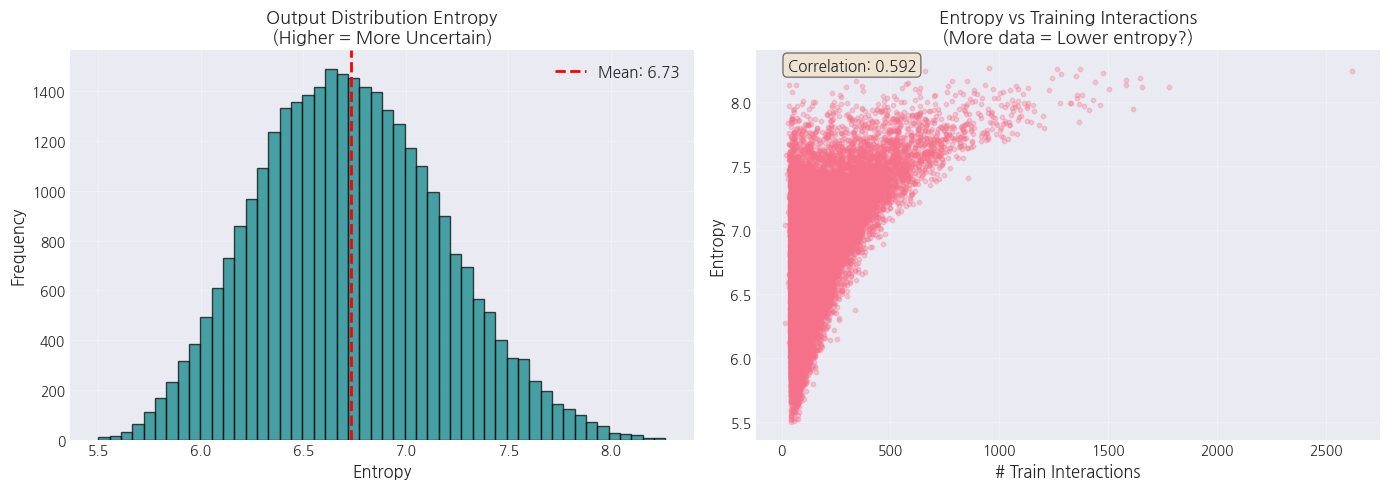


Entropy Statistics:
  Mean: 6.7326
  Std: 0.4474
  Min: 5.5022
  Max: 8.2643


In [16]:
# Probability entropy 분석
from scipy.stats import entropy

# 모든 유저에 대해 entropy 계산
print("Computing entropy for all users...")
all_entropies = []

batch_size = 256
for i in range(0, data_module.num_users, batch_size):
    batch_data = train_dense[i:i+batch_size]
    with torch.no_grad():
        logits, _, _ = model(batch_data)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    
    for prob in probs:
        all_entropies.append(entropy(prob))

all_entropies = np.array(all_entropies)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(all_entropies, bins=50, edgecolor='black', alpha=0.7, color='teal')
plt.axvline(all_entropies.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Mean: {all_entropies.mean():.2f}')
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Output Distribution Entropy\n(Higher = More Uncertain)', fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Entropy vs # Train Interactions
n_interactions = np.array(train_mat.sum(axis=1)).flatten()
plt.scatter(n_interactions, all_entropies, alpha=0.3, s=10)
plt.xlabel('# Train Interactions', fontsize=12)
plt.ylabel('Entropy', fontsize=12)
plt.title('Entropy vs Training Interactions\n(More data = Lower entropy?)', fontsize=13)
plt.grid(True, alpha=0.3)

# Correlation
corr = np.corrcoef(n_interactions, all_entropies)[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"\nEntropy Statistics:")
print(f"  Mean: {all_entropies.mean():.4f}")
print(f"  Std: {all_entropies.std():.4f}")
print(f"  Min: {all_entropies.min():.4f}")
print(f"  Max: {all_entropies.max():.4f}")

## Summary

이 노트북에서는 Multi-VAE 모델의 다양한 측면을 시각화했습니다:

1. **Input Data**: User-Item 상호작용 행렬과 sparsity 분석
2. **Data Split**: Random, Leave-One-Out, Temporal User, Temporal Global 4가지 전략 비교
3. **Predictions**: Top-K 추천 결과와 Recall@K 메트릭 평가
4. **Latent Space**: 유저의 잠재 표현을 3차원으로 시각화하고 Multivariate Normal Distribution 분석
5. **Output Distribution**: Multinomial 출력 분포와 entropy 분석

이러한 시각화를 통해 모델의 동작을 더 잘 이해하고, 개선점을 찾을 수 있습니다.